# Cassava Leaf Disease Classification
> Identify the type of disease present on a Cassava Leaf image

- toc: true
- badges: true
- categories: [plant,disease,classification,efficientnet]


In this competition, we are trying to identify common diseases of cassava crops using data science and machine learning. Previous methods of disease detection require farmers to solicit the help of government-funded agricultural experts to visually inspect and diagnose the plants. This suffers from being labor-intensive, low-supply and costly. Instead, it would be preferred if an automated pipeline based on mobile-quality photos of the cassava leafs could be developed.

This competition provides a farmer-crowdsourced dataset, labeled by experts at the National Crops Resources Research Institute (NaCRRI).

In this kernel, I will present a quick EDA.

In [1]:
#collapse-hide
import numpy as np
import pandas as pd
import seaborn as sns
import albumentations as A
import matplotlib.pyplot as plt
import os, gc, cv2, random, warnings, math, sys, json, pprint, pdb

import tensorflow as tf
from tensorflow.keras import backend as K
import tensorflow_hub as hub

from sklearn.model_selection import train_test_split

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
warnings.simplefilter('ignore')

> Tip: Adding seed helps reproduce results. Setting debug parameter wil run the model on smaller number of epochs to validate the architecture.

In [2]:
#hide
SEED = 16
DEBUG = False #@param {type:"boolean"}

os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [3]:
#hide
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [4]:
dataset_path = '/content/gdrive/MyDrive/1_AUSTIN CHEN/Data Scientist/Datasets/cassava-leaf-disease-classification'
os.chdir(dataset_path)
os.listdir(dataset_path)

['efficientnetb3_notop.h5',
 'label_num_to_disease_map.json',
 'sample_submission.csv',
 'train.csv',
 'cassava-leaf-disease-classification.zip',
 'test_images',
 'test_tfrecords',
 'train_images',
 'train_tfrecords',
 '.ipynb_checkpoints',
 '000_normalization.data-00000-of-00001',
 '000_normalization.index',
 'checkpoint',
 'best_model.h5']

In [13]:
df = pd.read_csv(dataset_path + '/train.csv')

In [14]:
df.head()

image_id  label
0  1000015157.jpg      0
1  1000201771.jpg      3
2   100042118.jpg      1
3  1000723321.jpg      1
4  1000812911.jpg      3

Check how many images are available in the training dataset and also check if each item in the training set are unique

In [9]:
#collapse-hide
print(f"There are {len(df)} train images")
len(df.image_id) == len(df.image_id.unique())

There are 21397 train images


True

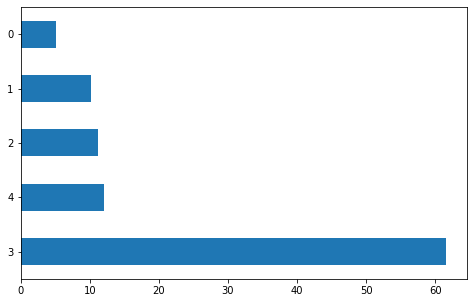

In [10]:
#collapse-hide
(df.label.value_counts(normalize=True) * 100).plot.barh(figsize = (8, 5))

In [15]:
df['filename'] = df['image_id'].map(lambda x : dataset_path + '/train_images/' + x)
df = df.drop(columns = ['image_id'])
df = df.sample(frac=1).reset_index(drop=True)

In [16]:
df.head()

label                                           filename
0      3  /content/gdrive/MyDrive/1_AUSTIN CHEN/Data Sci...
1      3  /content/gdrive/MyDrive/1_AUSTIN CHEN/Data Sci...
2      3  /content/gdrive/MyDrive/1_AUSTIN CHEN/Data Sci...
3      1  /content/gdrive/MyDrive/1_AUSTIN CHEN/Data Sci...
4      3  /content/gdrive/MyDrive/1_AUSTIN CHEN/Data Sci...

In [17]:
#hide
if DEBUG:
    _, df = train_test_split(
        df,
        test_size = 0.1,
        random_state=SEED,
        shuffle=True,
        stratify=df['label'])

In [18]:
with open(dataset_path + '/label_num_to_disease_map.json') as file:
  id2label = json.loads(file.read())
id2label

{'0': 'Cassava Bacterial Blight (CBB)',
 '1': 'Cassava Brown Streak Disease (CBSD)',
 '2': 'Cassava Green Mottle (CGM)',
 '3': 'Cassava Mosaic Disease (CMD)',
 '4': 'Healthy'}

In this case, we have 5 labels (4 diseases and healthy):

1. Cassava Bacterial Blight (CBB)
2. Cassava Brown Streak Disease (CBSD)
3. Cassava Green Mottle (CGM)
4. Cassava Mosaic Disease (CMD)
5. Healthy

In this case label 3, [Cassava Mosaic Disease (CMD)](https://en.wikipedia.org/wiki/Cassava_mosaic_virus) is the most common label. This imbalance may have to be addressed with a weighted loss function or oversampling. I might try this in a future iteration of this kernel or in a new kernel.

Let's check an example image to see what it looks like

In [19]:
from PIL import Image
img = Image.open(df[df.label==3]['filename'].iloc[0])

In [20]:
#hide_input
width, height = img.size
print(f"Width: {width}, Height: {height}")

Width: 800, Height: 600


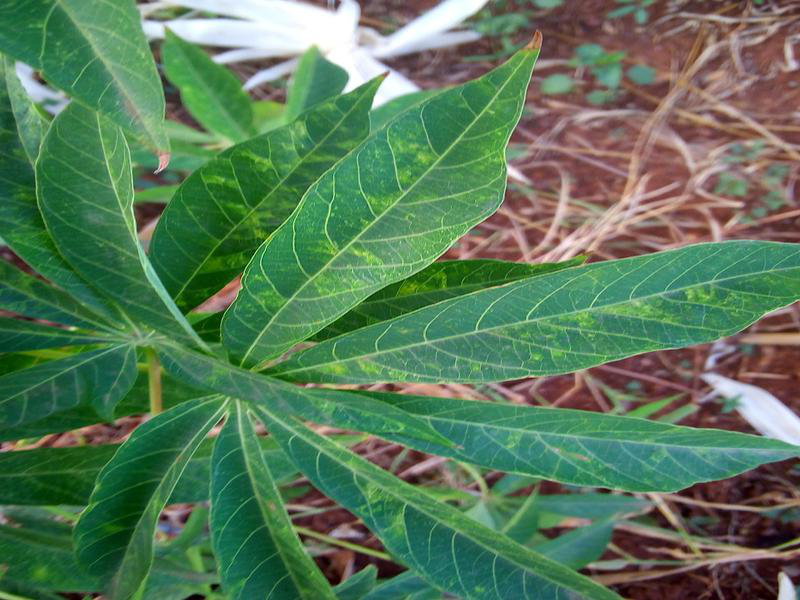

In [21]:
#hide_input
img

# EfficientNet

EfficientNet, first introduced in [Tan and Le, 2019](https://arxiv.org/abs/1905.11946) is among the most efficient models (i.e. requiring least FLOPS for inference) that reaches state-of-the-art accracy on both imagenet and common image classification transfer learning tasks.

The smallest base model is similar to [MnasNet](https://arxiv.org/abs/1807.11626), which reached near-SOTA with a significantly smaller model. By introducing a heuristic way to scale the model, EfficientNet provides a family of models (B0 to B7) that represents a good combination of efficiency and accuracy on a variety of scales. Such a scaling heuristics (**compound-scaling**, details see [Tan and Le, 2019](https://arxiv.org/abs/1905.11946)) allows the efficiency-oriented base model (B0) to surpass models at every scale, while avoiding extensive grid-search of hyperparameters.

A summary of the latest updates on the model is available at [here](), where various augmentation schemes and semi-supervised learning approaches are applied to further improve the imagenet performance of the models. These extensions of the model can be used by updating weights without changing model topology.


## B0 to B7 variants of EfficientNet
*(I will summarize the paper after finshing reading it)*

## Keras implementation of EfficientNet

An implementation of EfficientNet B0 to B7 has been shipped with `tf.keras` since TF2.3. To use EfficientNetB0 for classifying 1000 classes of images from imagenet, run:

```python
from tensorflow.keras.applications import EfficientNetB0
model = EfficientNetB0(weights='imagenet')
```

The B0 model takes input images of shape (224,224,3), and the input data should range [0,255]. ***Normailzation is included as part of the model.***

Because training EfficientNet on imagenet takes a tremendous amount of resources and several techniques that are not a part of the model architecture itself. Hence the Keras implementations by default loads pre-trained weights obtained via training with [AutoAugment](https://arxiv.org/abs/1805.09501).

From B0 to B7 base model, the input shapes are different. Here is a list of input shpae expected for each model:

| Base model | resolution|
|----------------|-----|
| EfficientNetB0 | 224 |
| EfficientNetB1 | 240 |
| EfficientNetB2 | 260 |
| EfficientNetB3 | 300 |
| EfficientNetB4 | 380 |
| EfficientNetB5 | 456 |
| EfficientNetB6 | 528 |
| EfficientNetB7 | 600 |

When the model is intended for transfer learning, the Keras implementation provides a option to remove the top layers:

```python
model = EfficientNetB0(include_top=False, weights='imagenet')
```

This option excludes the final Dense layer that turns 1280 features on the penultimate layer into prediction of the 1000 ImageNet classes. Replacing the top layer with custom layers allows using EfficientNet as a feature extractor in a transfer learning workflow.

Another argument in the model constructor worth noticing is drop_connect_rate which controls the dropout rate responsible for stochastic depth. This parameter serves as a toggle for extra regularization in finetuning, but does not affect loaded weights. For example, when stronger regularization is desired, try:

```python
model = EfficientNetB0(weights='imagenet', drop_connect_rate=0.4)
```
The default value for `drop_connect_rate` is 0.2


## Configuration

In [22]:
BASE_MODEL, IMG_SIZE = ("efficientnet_b3", 300) #param ["(\"efficientnet_b4\", 380)", "(\"efficientnet_b2\", 260)"] {type:"raw", allow-input: true}
BATCH_SIZE = 32 #param {type:"integer"}
IMG_SIZE = (IMG_SIZE, IMG_SIZE)
print("Using {} with input size {}".format(BASE_MODEL, IMG_SIZE))

Using efficientnet_b3 with input size (300, 300)


## Loading data
After my quick and rough EDA, let's load the PIL Image to a Numpy array, so we can move on to data augmentation.

In fastai, they have `item_tfms` and `batch_tfms` defined for their data loader API. The item transforms performs a fairly large crop to 224 and also apply other standard augmentations (in aug_tranforms) at the batch level on the GPU. The batch size is set to 32 here.

### Splitting

In [23]:
train_df, valid_df = train_test_split(
    df
    ,test_size = 0.2
    ,random_state = SEED
    ,shuffle = True
    ,stratify = df['label'])

### Constructing Dataset

In [24]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (train_df.filename.values,train_df.label.values))
valid_ds = tf.data.Dataset.from_tensor_slices(
    (valid_df.filename.values, valid_df.label.values))
adapt_ds = tf.data.Dataset.from_tensor_slices(
    train_df.filename.values)

In [25]:
for x,y in valid_ds.take(3):
  print(x, y)

tf.Tensor(b'/content/gdrive/MyDrive/1_AUSTIN CHEN/Data Scientist/Datasets/cassava-leaf-disease-classification/train_images/3227289141.jpg', shape=(), dtype=string) tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(b'/content/gdrive/MyDrive/1_AUSTIN CHEN/Data Scientist/Datasets/cassava-leaf-disease-classification/train_images/1494523424.jpg', shape=(), dtype=string) tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(b'/content/gdrive/MyDrive/1_AUSTIN CHEN/Data Scientist/Datasets/cassava-leaf-disease-classification/train_images/3290333742.jpg', shape=(), dtype=string) tf.Tensor(2, shape=(), dtype=int64)


In [26]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

> Important: At this point, you may have noticed that I have not used any kind of normalization or rescaling. I recently discovered that there is Normalization layer included in Keras' pretrained EfficientNet, as mentioned [here](https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/#keras-implementation-of-efficientnet). 

### Item transformation

Basically item transformations mainly make sure the input data is of the same size so that it can be collated in batches.


In [27]:
def process_image(filename, label=None):
  img = tf.io.read_file(filename)
  img = tf.image.decode_jpeg(img, channels=3)
  return img, label
  
def process_train(filename, label):
  img, _ = process_image(filename)
  img = tf.image.random_brightness(img, 0.3)
  img = tf.image.random_flip_left_right(img, seed=None)
  img = tf.image.random_crop(img, size=[*IMG_SIZE, 3])
  return img, label

def process_adapt(filename):
  img, _ = process_image(filename)
  img = tf.keras.layers.experimental.preprocessing.Rescaling(1.0 / 255)(img)
  return img

def process_valid(filename, label):
  img, _ = process_image(filename)
  img = tf.image.resize(img, [*IMG_SIZE])
  return img, label

In [28]:
train_ds = train_ds.map(process_train, num_parallel_calls=AUTOTUNE)
valid_ds = valid_ds.map(process_valid, num_parallel_calls=AUTOTUNE)
adapt_ds = adapt_ds.map(process_adapt, num_parallel_calls=AUTOTUNE)

In [29]:
def show_images(ds):
  _,axs = plt.subplots(4,6,figsize=(24,16))
  for ((x, y), ax) in zip(ds.take(24), axs.flatten()):
    ax.imshow(x.numpy().astype(np.uint8))
    ax.set_title(np.argmax(y))
    ax.axis('off')

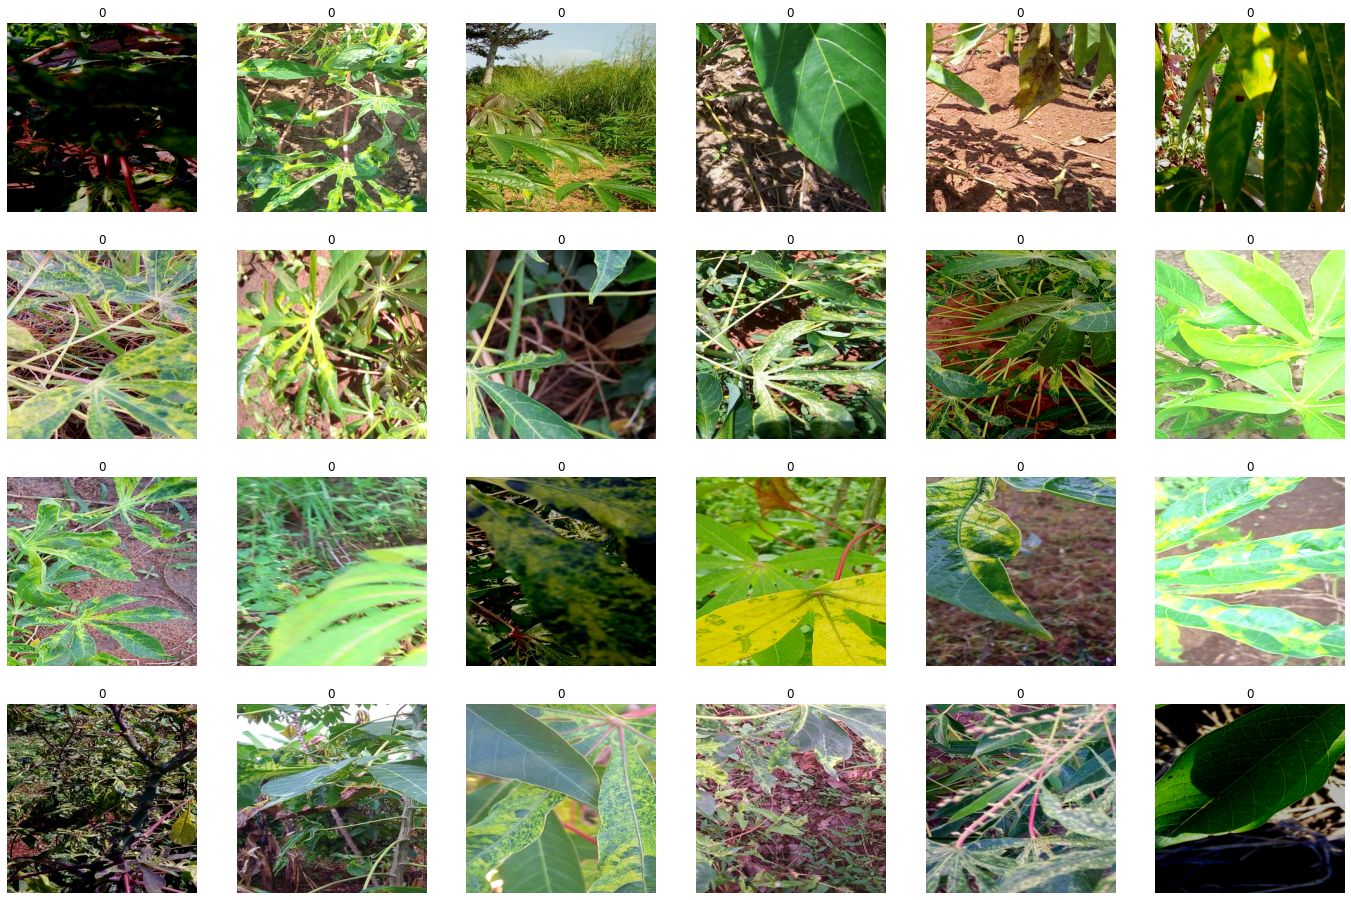

In [30]:
show_images(train_ds)

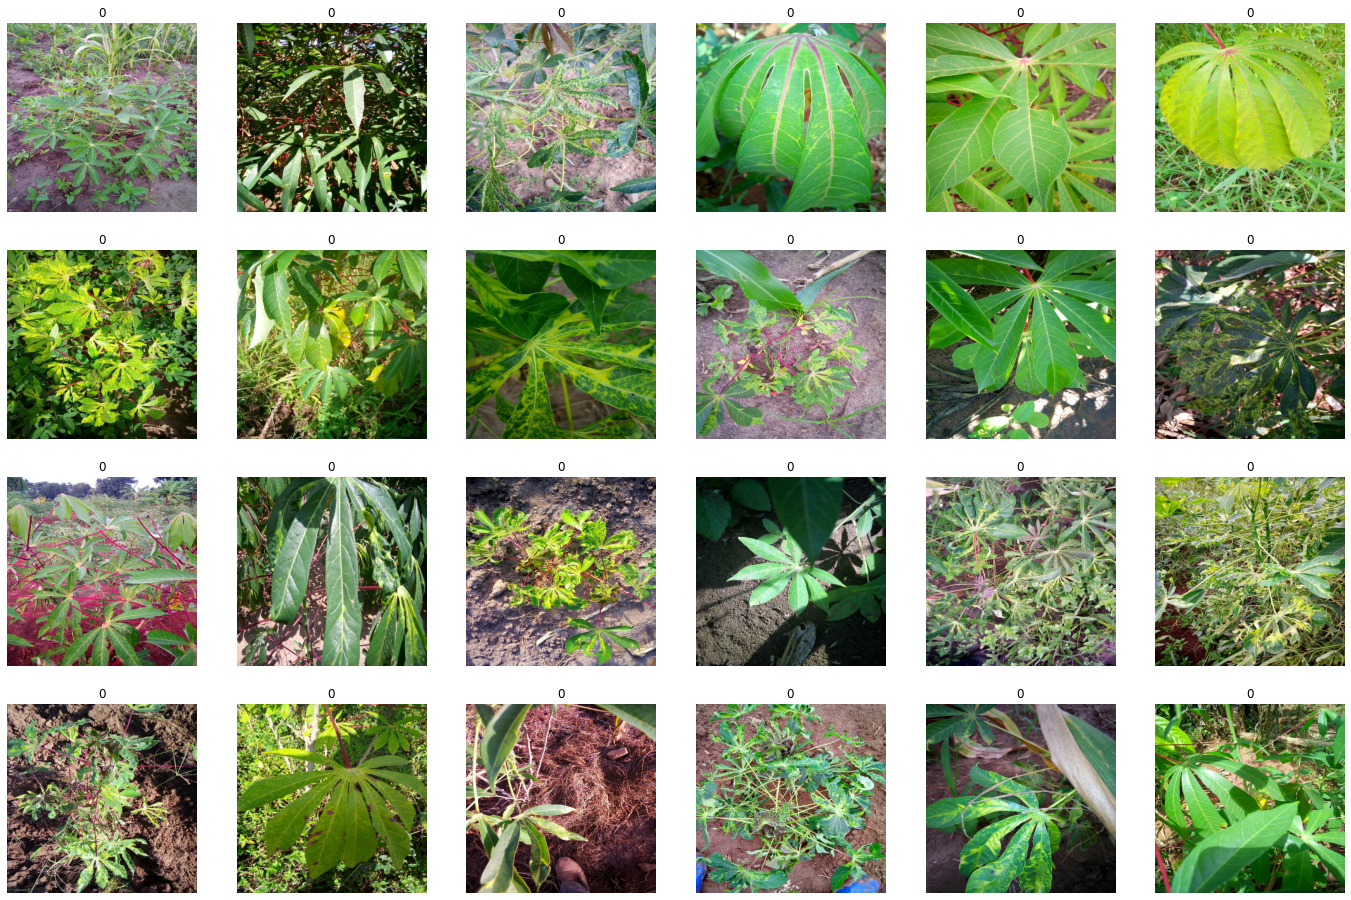

In [ ]:
show_images(valid_ds)

### Batching Dataset

> Note: I was shuffing the validation set which is a bug

In [33]:
train_ds_batch = (train_ds
                  .shuffle(buffer_size=1000)
                  .batch(BATCH_SIZE)
                  .prefetch(buffer_size=AUTOTUNE))

valid_ds_batch = (valid_ds
                  #.shuffle(buffer_size=1000)
                  .batch(BATCH_SIZE*2)
                  .prefetch(buffer_size=AUTOTUNE))

adapt_ds_batch = (adapt_ds
                  .shuffle(buffer_size=1000)
                  .batch(BATCH_SIZE)
                  .prefetch(buffer_size=AUTOTUNE))

In [34]:
image_batch, label_batch = next(iter(train_ds_batch))

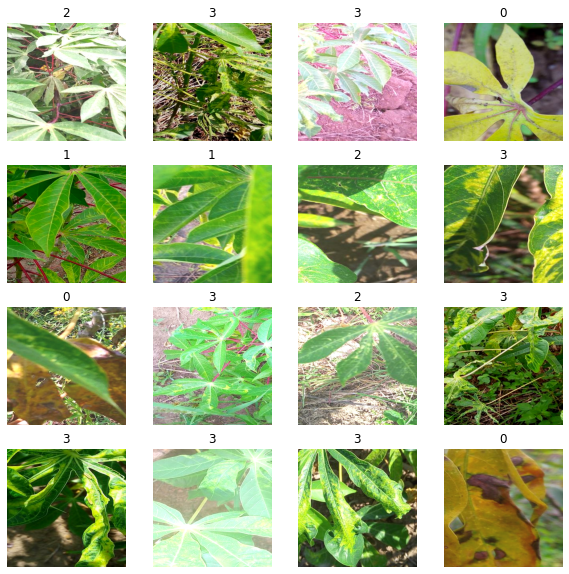

In [35]:
plt.figure(figsize=(10, 10))
for i in range(16):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i].numpy()
  plt.title(label)
  plt.axis("off")

## Batch augmentation

In [40]:
data_augmentation = tf.keras.Sequential(
    [
      tf.keras.layers.experimental.preprocessing.RandomCrop(*IMG_SIZE),
      tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
      tf.keras.layers.experimental.preprocessing.RandomRotation(0.25),
      tf.keras.layers.experimental.preprocessing.RandomZoom((-0.2, 0)),
      tf.keras.layers.experimental.preprocessing.RandomContrast((0.2,0.2))
    ]
)

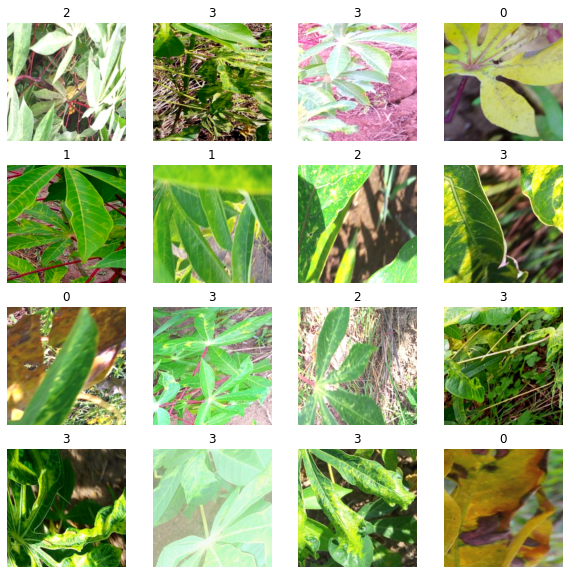

In [41]:
plt.figure(figsize=(10, 10))
for i in range(16):
    augmented_images = data_augmentation(image_batch)
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(augmented_images[i].numpy().astype("uint8"))
    label = label_batch[i].numpy()
    plt.title(label)
    plt.axis("off")

## Building a model

I am using an EfficientNetB3 on top of which I add some output layers to predict our 5 disease classes. I decided to load the imagenet pretrained weights locally to keep the internet off (part of the requirements to submit a kernal to this competition).

In [36]:
from tensorflow.keras.applications import EfficientNetB3

In [ ]:
#hide
!wget https://storage.googleapis.com/keras-applications/efficientnetb3_notop.h5

--2020-12-17 00:00:05--  https://storage.googleapis.com/keras-applications/efficientnetb3_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.9.208, 172.217.12.240, 172.217.164.176, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.9.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 43941136 (42M) [application/x-hdf]
Saving to: ‘efficientnetb3_notop.h5’

efficientnetb3_noto 100%[===================>]  41.91M  72.3MB/s    in 0.6s    

2020-12-17 00:00:06 (72.3 MB/s) - ‘efficientnetb3_notop.h5’ saved [43941136/43941136]



In [48]:
efficientnet = EfficientNetB3(
    weights = dataset_path + "/efficientnetb3_notop.h5", 
    include_top = False, 
    input_shape = (*IMG_SIZE, 3), 
    drop_connect_rate = 0.4)

In [46]:
def build_model(base_model, num_class):
  inputs = tf.keras.layers.Input(shape=(*IMG_SIZE, 3))
  x = data_augmentation(inputs)
  
  x = base_model(x)

  # Rebuild top
  x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(x)
  #x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Dropout(0.4, name="top_dropout")(x)
  outputs = tf.keras.layers.Dense(num_class, activation="softmax", name="pred")(x)

  model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

  return model

In [51]:
#inputs       = tf.keras.layers.Input(shape=(*IMG_SIZE, 3))
#augmented    = data_augmentation(inputs)
#efficientnet = efficientnet(augmented)
#pooling      = tf.keras.layers.GlobalAveragePooling2D()(efficientnet)
#dropout      = tf.keras.layers.Dropout(0.4)(pooling)
#outputs      = tf.keras.layers.Dense(len(id2label), activation="softmax")(dropout)
#model        = tf.keras.models.Model(inputs=inputs, outputs=outputs)

In [49]:
model = build_model(base_model=efficientnet, num_class=len(id2label))

In [53]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 300, 300, 3)       0         
_________________________________________________________________
efficientnetb3 (Functional)  (None, 10, 10, 1536)      10783535  
_________________________________________________________________
avg_pool (GlobalAveragePooli (None, 1536)              0         
_________________________________________________________________
top_dropout (Dropout)        (None, 1536)              0         
_________________________________________________________________
pred (Dense)                 (None, 5)                 7685      
Total params: 10,791,220
Trainable params: 10,703,917
Non-trainable params: 87,303
__________________________________________

## Fine tune

The 3rd layer of the Efficient is the Normalization layer, which can be tuned to our new dataset instead of `imagenet`. Be patient on this one, it does take a bit of time as we're going through the entire training set.

In [ ]:
%%time
model.get_layer('efficientnetb3').get_layer('normalization').adapt(adapt_ds_batch)

CPU times: user 13min 17s, sys: 11.6 s, total: 13min 29s
Wall time: 27min 17s


In [ ]:
model.save_weights(filepath = dataset_path + "/000_normalization")

## Training

I always wanted to try the new `CosineDecay` function implemented in `tf.keras` as it seemed promising and I struggled to find the right settings (if there were any) for the `ReduceLROnPlateau`

In [ ]:
EPOCHS = 8
decay_steps = int(round(len(train_df)/BATCH_SIZE)) * EPOCHS
cosine_decay = tf.keras.experimental.CosineDecay(
    initial_learning_rate=1e-4,
    decay_steps=decay_steps,
    alpha=0.3)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='best_model.h5',
        monitor='val_loss',
        save_best_only=True)
    ]

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(cosine_decay),
              metrics=["accuracy"])

In [ ]:
history = model.fit(train_ds_batch,
                    epochs = EPOCHS,
                    validation_data=valid_ds_batch,
                    callbacks=callbacks)

Epoch 1/8
535/535 [==============================] - 1080s 2s/step - loss: 0.7556 - accuracy: 0.7221 - val_loss: 0.6072 - val_accuracy: 0.7759
Epoch 2/8
535/535 [==============================] - 669s 1s/step - loss: 0.5565 - accuracy: 0.8015 - val_loss: 0.6240 - val_accuracy: 0.7643
Epoch 3/8
535/535 [==============================] - 669s 1s/step - loss: 0.5112 - accuracy: 0.8199 - val_loss: 0.6173 - val_accuracy: 0.7659
Epoch 4/8
535/535 [==============================] - 672s 1s/step - loss: 0.4726 - accuracy: 0.8349 - val_loss: 0.5731 - val_accuracy: 0.7825
Epoch 5/8
535/535 [==============================] - 671s 1s/step - loss: 0.4488 - accuracy: 0.8423 - val_loss: 0.5691 - val_accuracy: 0.7886
Epoch 6/8
535/535 [==============================] - 669s 1s/step - loss: 0.4246 - accuracy: 0.8470 - val_loss: 0.5479 - val_accuracy: 0.7995
Epoch 7/8
535/535 [==============================] - 666s 1s/step - loss: 0.4091 - accuracy: 0.8572 - val_loss: 0.5511 - val_accuracy: 0.8005
Epoch

## Evaluating


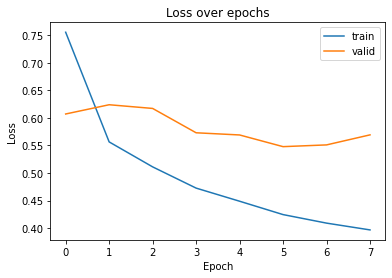

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'valid'], loc='best')
plt.show()

We load the best weight that were kept from the training phase. Just to check how our model is performing, we will attempt predictions over the validation set. This can help to highlight any classes that will be consistently miscategorised.

In [54]:
model.load_weights('best_model.h5')

## Prediction

In [55]:
def scan_over_image(img_path, crop_size=512):
    '''
    Will extract 512x512 images covering the whole original image
    with some overlap between images
    '''
    
    img = Image.open(img_path)
    img_height, img_width = img.size
    img = np.array(img)
    
    y = random.randint(0,img_height-crop_size)
    x = random.randint(0,img_width-crop_size)

    x_img_origins = [0,img_width-crop_size]
    y_img_origins = [0,img_height-crop_size]
    img_list = []
    for x in x_img_origins:
        for y in y_img_origins:
            img_list.append(img[x:x+crop_size , y:y+crop_size,:])
  
    return np.array(img_list)

In [56]:
def display_samples(img_path):
    '''
    Display all 512x512 images extracted from original images
    '''
    
    img_list = scan_over_image(img_path)
    sample_number = len(img_list)
    fig = plt.figure(figsize = (8,sample_number))
    for i in range(0,sample_number):
        ax = fig.add_subplot(2, 4, i+1)
        ax.imshow(img_list[i])
        ax.set_title(str(i))
    plt.tight_layout()
    plt.show()

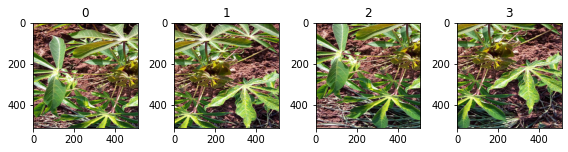

In [65]:
display_samples(train_df.sample(1).filename.values[0])

In [67]:
tta_layers = tf.keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.experimental.preprocessing.RandomZoom((-0.2, 0.2)),
        tf.keras.layers.experimental.preprocessing.RandomContrast((0.2,0.2))
    ]
)

In [69]:
def predict_and_vote(image_filename, folder, TTA_runs=4):
    '''
    Run the model over 4 local areas of the given image,
    before making a decision depending on the most predicted
    disease.
    '''
    
    #apply TTA to each of the 4 images and sum all predictions for each local image
    localised_predictions = []
    local_image_list = scan_over_image(folder+image_filename)
    for local_image in local_image_list:
        local_image = tf.expand_dims(local_image,0)
        augmented_images = [test_time_augmentation_layers(local_image) for i in range(TTA_runs)]
        predictions = model.predict(np.array(augmented_images[0]))
        localised_predictions.append(np.sum(predictions, axis=0))
    
    #sum all predictions from all 4 images and retrieve the index of the highest value
    global_predictions = np.sum(np.array(localised_predictions),axis=0)
    final_prediction = np.argmax(global_predictions)
    
    return final_prediction

In [68]:
def run_predictions_over_image_list(image_list, folder):
    predictions = []
    with tqdm(total=len(image_list)) as pbar:
        for image_filename in image_list:
            pbar.update(1)
            predictions.append(predict_and_vote(image_filename, folder))
    return predictions

In [ ]:
validation_df["results"] = run_predictions_over_image_list(valid_df["filename"], training_folder)

# 1% Better Everyday

**reference**
- https://www.kaggle.com/frlemarchand/efficientnet-aug-tf-keras-for-cassava-diseases
- https://www.kaggle.com/harveenchadha/efficientnetb3-keras-tf2-baseline-training
- https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/#keras-implementation-of-efficientnet
- https://www.kaggle.com/c/cassava-leaf-disease-classification/leaderboard
- https://www.tensorflow.org/guide/gpu_performance_analysis
- https://www.tensorflow.org/guide/data_performance#prefetching
- https://www.tensorflow.org/guide/data_performance_analysis

---

**todos**
- Learn more about the `adapt` function that being used to retrain the normalization layer of the EfficientNetB3.
- Read the EfficientNet paper and summarize in one of the section of this notebook.
- See if I can integrate the Cutmix/Mixup augmentations in the appendix into our existing notebook.
- `Hence the Keras implementations by default loads pre-trained weights obtained via training with AutoAugment.` What does it mean by this comment?

---

**done**
- Try out the `data_generator` and the `data_frame_iterator`
- Removing normalizaiton step in generator since in EfficientNet, normalization is done within the model itself and the model expects input in the range of [0,255]
- Find out the intuition and the difference between `item_tfm` and `batch_tfm`
> In fastai, `item_tfm` defines the transforms that are done on the CPU and `batch_tfm` defines those done on the GPU.

- Customize my own data generator as fastai creates their `Dataloader`
> No need, things are much easier than what I was originally expecting. Please refer to the `Loading data` section in this notebook.

- The 3rd layer of the Efficientnet is the Normalization layer, which can be tuned to our new dataset instead of `imagenet`. Be patient on this one, it does take a bit of time we're going through the entire training set.




# Appendix

The `albumentation` is primarily used for resizing and normalization.

In [ ]:
# For Training 
def albu_transforms_train(data_resize): 
    return A.Compose([
            A.ToFloat(),
            A.Resize(data_resize, data_resize),
        ], p=1.)

# For Validation 
def albu_transforms_valid(data_resize): 
    return A.Compose([
            A.ToFloat(),
            A.Resize(data_resize, data_resize),
        ], p=1.)

In [ ]:
def CutMix(image, label, DIM, PROBABILITY = 1.0):
    # input image - is a batch of images of size [n,dim,dim,3] not a single image of [dim,dim,3]
    # output - a batch of images with cutmix applied
    CLASSES = 5
    
    imgs = []; labs = []
    for j in range(len(image)):
        # DO CUTMIX WITH PROBABILITY DEFINED ABOVE
        P = tf.cast( tf.random.uniform([],0,1)<=PROBABILITY, tf.int32)
        
        # CHOOSE RANDOM IMAGE TO CUTMIX WITH
        k = tf.cast( tf.random.uniform([],0,len(image)),tf.int32)
        
        # CHOOSE RANDOM LOCATION
        x = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
        y = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
        
        b = tf.random.uniform([],0,1) # this is beta dist with alpha=1.0
        
        WIDTH = tf.cast( DIM * tf.math.sqrt(1-b),tf.int32) * P
        ya = tf.math.maximum(0,y-WIDTH//2)
        yb = tf.math.minimum(DIM,y+WIDTH//2)
        xa = tf.math.maximum(0,x-WIDTH//2)
        xb = tf.math.minimum(DIM,x+WIDTH//2)

        # MAKE CUTMIX IMAGE
        one = image[j,ya:yb,0:xa,:]
        two = image[k,ya:yb,xa:xb,:]
        three = image[j,ya:yb,xb:DIM,:]
        middle = tf.concat([one,two,three],axis=1)
        img = tf.concat([image[j,0:ya,:,:],middle,image[j,yb:DIM,:,:]],axis=0)
        imgs.append(img)
        
        # MAKE CUTMIX LABEL
        a = tf.cast(WIDTH*WIDTH/DIM/DIM,tf.float32)
        labs.append((1-a)*label[j] + a*label[k])
            
    # RESHAPE HACK SO TPU COMPILER KNOWS SHAPE OF OUTPUT TENSOR (maybe use Python typing instead?)
    image2 = tf.reshape(tf.stack(imgs),(len(image),DIM,DIM,3))
    label2 = tf.reshape(tf.stack(labs),(len(image),CLASSES))
    
    return image2,label2

In [ ]:
def MixUp(image, label, DIM, PROBABILITY = 1.0):
    # input image - is a batch of images of size [n,dim,dim,3] not a single image of [dim,dim,3]
    # output - a batch of images with mixup applied
    CLASSES = 5
    
    imgs = []; labs = []
    for j in range(len(image)):
        # DO MIXUP WITH PROBABILITY DEFINED ABOVE
        P = tf.cast( tf.random.uniform([],0,1)<=PROBABILITY, tf.float32)
                   
        # CHOOSE RANDOM
        k = tf.cast( tf.random.uniform([],0,len(image)),tf.int32)
        a = tf.random.uniform([],0,1)*P # this is beta dist with alpha=1.0
                    
        # MAKE MIXUP IMAGE
        img1 = image[j,]
        img2 = image[k,]
        imgs.append((1-a)*img1 + a*img2)
                    
        # MAKE CUTMIX LABEL
        labs.append((1-a)*label[j] + a*label[k])
            
    # RESHAPE HACK SO TPU COMPILER KNOWS SHAPE OF OUTPUT TENSOR (maybe use Python typing instead?)
    image2 = tf.reshape(tf.stack(imgs),(len(image),DIM,DIM,3))
    label2 = tf.reshape(tf.stack(labs),(len(image),CLASSES))
    return image2,label2